In [382]:
import re
import pandas as pd
import numpy as np


from collections import Counter

from wordcloud import WordCloud

import seaborn as sns
from matplotlib import pyplot as plt

from reviews.preprocess import preprocess, strip_html
from reviews.config import processed_data_dir

# Read Dataset

In [500]:
# load data
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")

## Products

In [501]:
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         32720 non-null  object
 1   brand        32720 non-null  object
 2   category     32720 non-null  object
 3   date         32720 non-null  object
 4   description  32720 non-null  object
 5   price        32720 non-null  object
 6   title        32720 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [502]:
prod_df.head(10)

,asin,brand,category,date,description,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...","May 20, 2009",[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","May 5, 2012","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...","June 1, 1999",[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...","September 4, 1973",[APC 650 VA Uninterruptable Power Supply],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...","September 4, 1999",[Unleash incredible graphics performance!],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...","June 1, 1999",[Based on the award-winning Sound Blaster 16 t...,$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...","September 4, 1999",[Unleash incredible graphics performance!],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...","September 4, 1999",[Monster Sound MX300 is the new-generation PCI...,,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","September 4, 1973","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...","September 4, 1999",[Adding memory to your new or existing desktop...,,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [ ]:
# keep the first subcategory
prod_df["category"] = prod_df["category"].apply(
    lambda x: x[4] if len(x) > 4 else "other"
)

# join description in a single string
prod_df["description"] = prod_df["description"].apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 20, "price"] = np.nan

In [504]:
prod_df.head(10)

,asin,brand,category,date,description,price,title
0,7500653883,ECS Elitegroup,Motherboards,"May 20, 2009",NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,Internal TV Tuner & Capture Cards,"May 5, 2012","Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,Internal Modems,"June 1, 1999",NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,Internal Power Supplies,"September 4, 1973",APC 650 VA Uninterruptable Power Supply,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,Graphics Cards,"September 4, 1999",Unleash incredible graphics performance!,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,Internal Sound Cards,"June 1, 1999",Based on the award-winning Sound Blaster 16 te...,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,Graphics Cards,"September 4, 1999",Unleash incredible graphics performance!,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,Graphics Cards,"September 4, 1999",Monster Sound MX300 is the new-generation PCI ...,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,Graphics Cards,"September 4, 1973","Based on the NVIDIA RIVA TNT Ultra chip set, D...",NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,Memory,"September 4, 1999",Adding memory to your new or existing desktop ...,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [505]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")
prod_df["date"] = pd.to_datetime(prod_df["date"], errors="coerce")

### Check missing or null values

In [506]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   asin         32720 non-null  string        
 1   brand        32640 non-null  category      
 2   category     32719 non-null  category      
 3   date         32126 non-null  datetime64[ns]
 4   description  30405 non-null  string        
 5   price        15855 non-null  float64       
 6   title        32720 non-null  string        
dtypes: category(2), datetime64[ns](1), float64(1), string(3)
memory usage: 1.4 MB


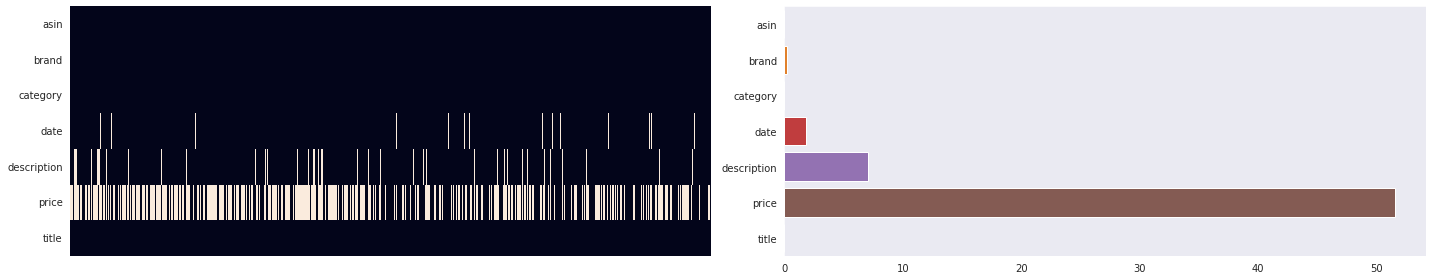

In [507]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(prod_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=prod_df.columns,
    x=(len(prod_df) - prod_df.count()) / len(prod_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

### Duplicates

In [508]:
# remove duplicates
prod_df.drop_duplicates(inplace=True)

## Reviews

In [448]:
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   asin       269027 non-null  object
 1   overall    269027 non-null  object
 2   summary    269027 non-null  object
 3   text       269025 non-null  object
 4   timestamp  269027 non-null  object
 5   vote       269027 non-null  object
dtypes: object(6)
memory usage: 12.3+ MB


In [447]:
review_df.head(10)

,asin,overall,summary,text,timestamp,vote
0,7799813393,3,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


### 

In [ ]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote"]:
    review_df[col] = review_df[col].astype("string").apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [452]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")

In [469]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  category      
 1   overall    269027 non-null  category      
 2   summary    269027 non-null  string        
 3   text       269025 non-null  string        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 9.3 MB


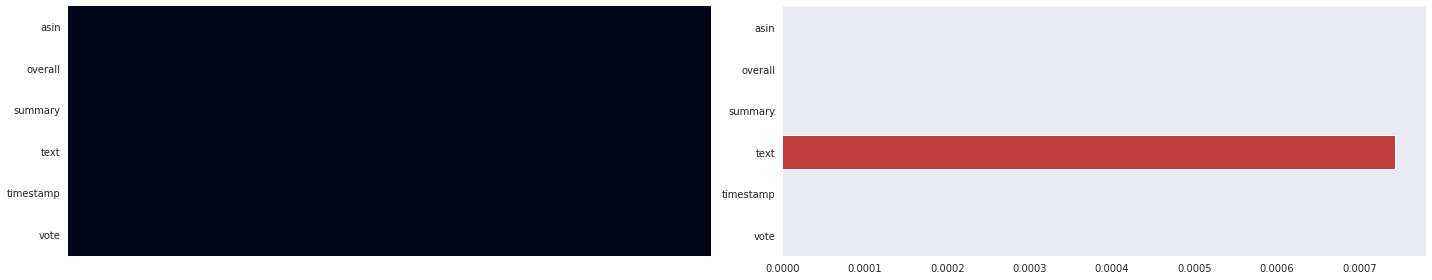

In [474]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(review_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=review_df.columns,
    x=(len(review_df) - review_df.count()) / len(review_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

#### TODO: Handle one and two characters texts (emoji)

In [493]:
list(review_df[review_df["text"].str.len() == 1]["text"])

['A',
 'k',
 '1',
 '.',
 '1',
 'A',
 '1',
 '1',
 'A',
 'A',
 'a',
 '.',
 'K',
 'K',
 'A',
 'A',
 'A',
 'A',
 'A',
 'K',
 'A',
 '1',
 'A',
 'a',
 'A',
 'A',
 'A',
 '.',
 'A',
 'a',
 'A',
 '1',
 'A',
 'A',
 'k',
 'A',
 '1',
 '1',
 'A',
 'a',
 'A',
 'C',
 'K',
 '1',
 '1',
 'A',
 '1',
 'a',
 'K',
 'a',
 'K',
 'd',
 'A',
 'K',
 'D',
 'A',
 '1',
 'a',
 'A',
 'c',
 'a']

In [492]:
list(review_df[review_df["text"].str.len() == 2]["text"])

['OK',
 'ok',
 ':)',
 'ya',
 'ok',
 'ok',
 'Ok',
 'OK',
 ':)',
 'ok',
 'op',
 'Ok',
 'ok',
 'ok',
 'ok',
 ':)',
 'Ok',
 'A+',
 'ok',
 'ok',
 'OK',
 'ok',
 'Ok',
 'A1',
 'A+',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'A1',
 'OK',
 'OK',
 'ok',
 'ok',
 'OK',
 'A+',
 'A+',
 'ok',
 'ok',
 'OK',
 'ok',
 'ok',
 'OK',
 'ok',
 'no',
 'ok',
 'OK',
 'OK',
 'ok',
 'ok',
 'OK',
 'OK',
 'A+',
 'ty',
 'ty',
 'ok',
 'ok',
 'OK',
 'ok',
 'ok',
 'Ok',
 'A+',
 'ok',
 'ok',
 'Ok',
 'ok',
 'OK',
 'ok',
 'Ok',
 'a+',
 'ok',
 'ok',
 'A+',
 'ok',
 'ok',
 'ok',
 'ok',
 'OK',
 'ok',
 'ok',
 'Ok',
 'A+',
 'A+',
 'ok',
 'A+',
 'Ok',
 'ok',
 'ok',
 'A+',
 'A+',
 'ok',
 'ok',
 'ok',
 'A+',
 'ok',
 'OK',
 'ok',
 'Ok',
 'ok',
 'OK',
 'ok',
 'A+',
 'a+',
 'Ok',
 'A+',
 'OK',
 'ty',
 'ok',
 'ok',
 'ok',
 'Ok',
 'A+',
 'A+',
 'ok',
 'ok',
 'ok',
 'A+',
 'Ok',
 'ok',
 'Ok',
 'ok',
 'ok',
 'OK',
 'ok',
 'OK',
 'Ok',
 'ok',
 'OK',
 'ok',
 'ok',
 'ok',
 'ok',
 'ty',
 'ok',
 'OK',
 'ok',
 'ok',
 'ty',
 'Ok',
 ':)',
 'ok',

### Duplicates

In [530]:
# remove duplicates
review_df.drop_duplicates(inplace=True)

### Language Detction

In [ ]:
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [ ]:
# keep eng only reviews
from reviews.lang_identification import LanguageIdentification

lang_detector = LanguageIdentification()

for x in review_df["text"].tolist():
    review_df["lang"] = lang_detector.predict_lang(x)

In [ ]:
review_df = review_df.loc[review_df["text"].str.len() > 40]

In [ ]:
from reviews.lang_identification import LanguageIdentification

lang_detector = LanguageIdentification()

from reviews.preprocess import (
    remove_non_ascii,
    remove_urls,
    remove_spaces,
    strip_html,
    remove_special_chars,
    remove_numbers,
)

langs = []
for i, row in review_df.iterrows():
    text = (
        row["text"].replace("\n", " ").lower()
        + " "
        + row["summary"].replace("\n", " ").lower()
    )
    text = remove_urls(text)
    text = strip_html(text)
    text = remove_numbers(text)
    lang = lang_detector.predict_lang(text)
    langs.append(lang)

review_df["lang"] = langs

In [ ]:
review_df["lang"].value_counts()

In [ ]:
review_df.loc[review_df["lang"] == "es"]

### Merge with Products

In [ ]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")

data_df.info()

In [525]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")

# Analysis

In [ ]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

## ASIN

In [ ]:
# number of reviews per product(ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(40, 7))
plt.xticks(rotation=45)
sns.barplot(data[0], data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print(z["asin"].mean())

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = sns.countplot(data_df["category"].astype("string"))
plt.xticks(rotation=45)
fig.tight_layout()

### Overall

<AxesSubplot:>

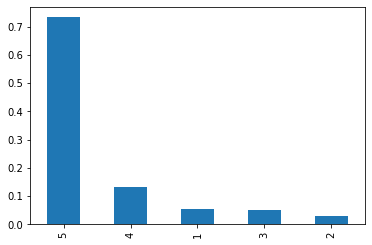

In [15]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(kind="bar")

In [ ]:
# min and max of overall mean
print((data_df.groupby("asin")["overall"].mean()).min())
print((data_df.groupby("asin")["overall"].mean()).max())

# mean of overall
print(data_df.groupby("asin")["overall"].mean())

<AxesSubplot:>

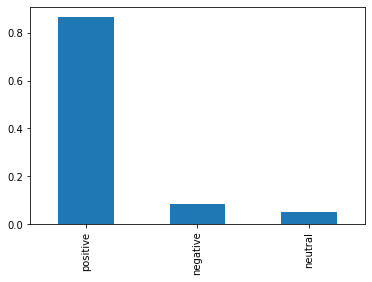

In [22]:
polarity_overall = data_df["overall"].apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)
polarity_overall.value_counts(normalize=True).plot(kind="bar")

## Vote

In [ ]:
# count of helpful vote number
from collections import Counter
from locale import normalize
import seaborn as sns
from matplotlib import pyplot as plt

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(40))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

In [ ]:
# min and max of vote mean
print((data_df.groupby("asin")["vote"].mean()).min())
print((data_df.groupby("asin")["vote"].mean()).max())

# mean of vote
print(data_df.groupby("asin")["vote"].mean())

## Brand Reviewed

### Most Reviewed Brand

In [ ]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

In [ ]:
c = Counter(list(prod_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Mean Overall per Brand

In [ ]:
# mean valuation for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(50))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"overall": [np.mean]})
df.columns = ["mean_overall"]
df.reset_index(inplace=True)

_, ax = plt.subplots(figsize=(40, 5))
plt.xticks(rotation=45)
sns.barplot(
    df["brand"],
    df["mean_overall"],
    ax=ax,
    order=df.sort_values(by="mean_overall", ascending=False).brand,
)

pass

### Mean Vote per Brand

In [ ]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(50))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

_, ax = plt.subplots(figsize=(40, 5))
plt.xticks(rotation=45)
sns.barplot(
    df["brand"],
    df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)

pass

## Review Time Series

In [ ]:
# numero di reviews nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
sns.histplot(data_df[data_df["brand"] == "AMD"]["timestamp"], ax=ax)

pass

In [ ]:
# overall nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
y = data_df[data_df["brand"] == "Intel"]["overall"]
x = data_df[data_df["brand"] == "Intel"]["timestamp"]
sns.lineplot(x, y, ax=ax)

pass

In [ ]:
# vote nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
x = data_df[data_df["brand"] == "Intel"]["vote"]
y = data_df[data_df["brand"] == "Intel"]["timestamp"]
sns.lineplot(y, x, ax=ax)

pass

## Review Text and Summary

### Summary

In [ ]:
data_df["summary"].head(10)

In [ ]:
# most common tokens summary

tokens = []
for x in data_df["summary"].tolist():
    for token in preprocess(x, sentences=False):
        tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

In [ ]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Text

In [ ]:
data_df["text"].head(10)

In [ ]:
# most common tokens summary
tokens = []
for x in data_df["text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

In [ ]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()